# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.linalg import svd
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, OrdinalEncoder
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector, RFE
import category_encoders as ce

import warnings
warnings.filterwarnings('ignore')

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [2]:
vehicles = pd.read_csv('data/Vehicles.csv')

In [46]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [10]:
print(vehicles.shape)
vehicles.sample(10)

(426880, 18)


,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
362305,7306131113,tri-cities,42990,2020.0,acura,mdx technology pkg sport,good,NaN,other,3207.0,clean,other,5J8YD3H53LL000555,fwd,NaN,other,white,tn
10659,7316534539,phoenix,19000,2017.0,chevrolet,colorado,good,6 cylinders,gas,84000.0,salvage,automatic,NaN,4wd,NaN,pickup,white,az
126516,7304651056,northwest GA,17590,2017.0,toyota,camry le sedan 4d,good,NaN,other,41606.0,clean,other,4T1BF1FKXHU325213,fwd,NaN,sedan,NaN,ga
337064,7311049179,pittsburgh,16990,2017.0,kia,forte5 ex hatchback 4d,good,NaN,gas,34723.0,clean,other,KNAFX5A80H5719008,fwd,NaN,hatchback,blue,pa
134656,7313646162,lewiston / clarkston,9980,2014.0,ford,fiesta,NaN,4 cylinders,gas,84868.0,clean,automatic,3FADP4EJ5EM103219,fwd,NaN,hatchback,white,id
286619,7315073179,akron / canton,3995,2007.0,toyota,prius,NaN,4 cylinders,other,186000.0,clean,automatic,JTDKB20U477629294,fwd,NaN,sedan,silver,oh
359210,7315435522,nashville,13200,2013.0,gmc,acadia sle,excellent,6 cylinders,gas,84531.0,rebuilt,automatic,1GKKRPKD2DJ147741,fwd,full-size,SUV,custom,tn
69989,7302367239,visalia-tulare,17000,2017.0,ford,escape,NaN,4 cylinders,gas,43787.0,clean,automatic,1FMCU0GD4HUE16854,fwd,NaN,SUV,grey,ca
270837,7307819287,hudson valley,4500,2012.0,ford,fusion,NaN,NaN,gas,153163.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,ny
296337,7311913804,columbus,1150,2005.0,nissan,xterra 4x4,good,6 cylinders,gas,172872.0,clean,automatic,5N1AN08W45C630541,4wd,mid-size,SUV,black,oh


In [47]:
## Drop NaN and duplicates form the dataset
clean_vehicles = vehicles.dropna()
clean_vehicles = clean_vehicles.drop_duplicates()
clean_vehicles.shape

(34868, 18)

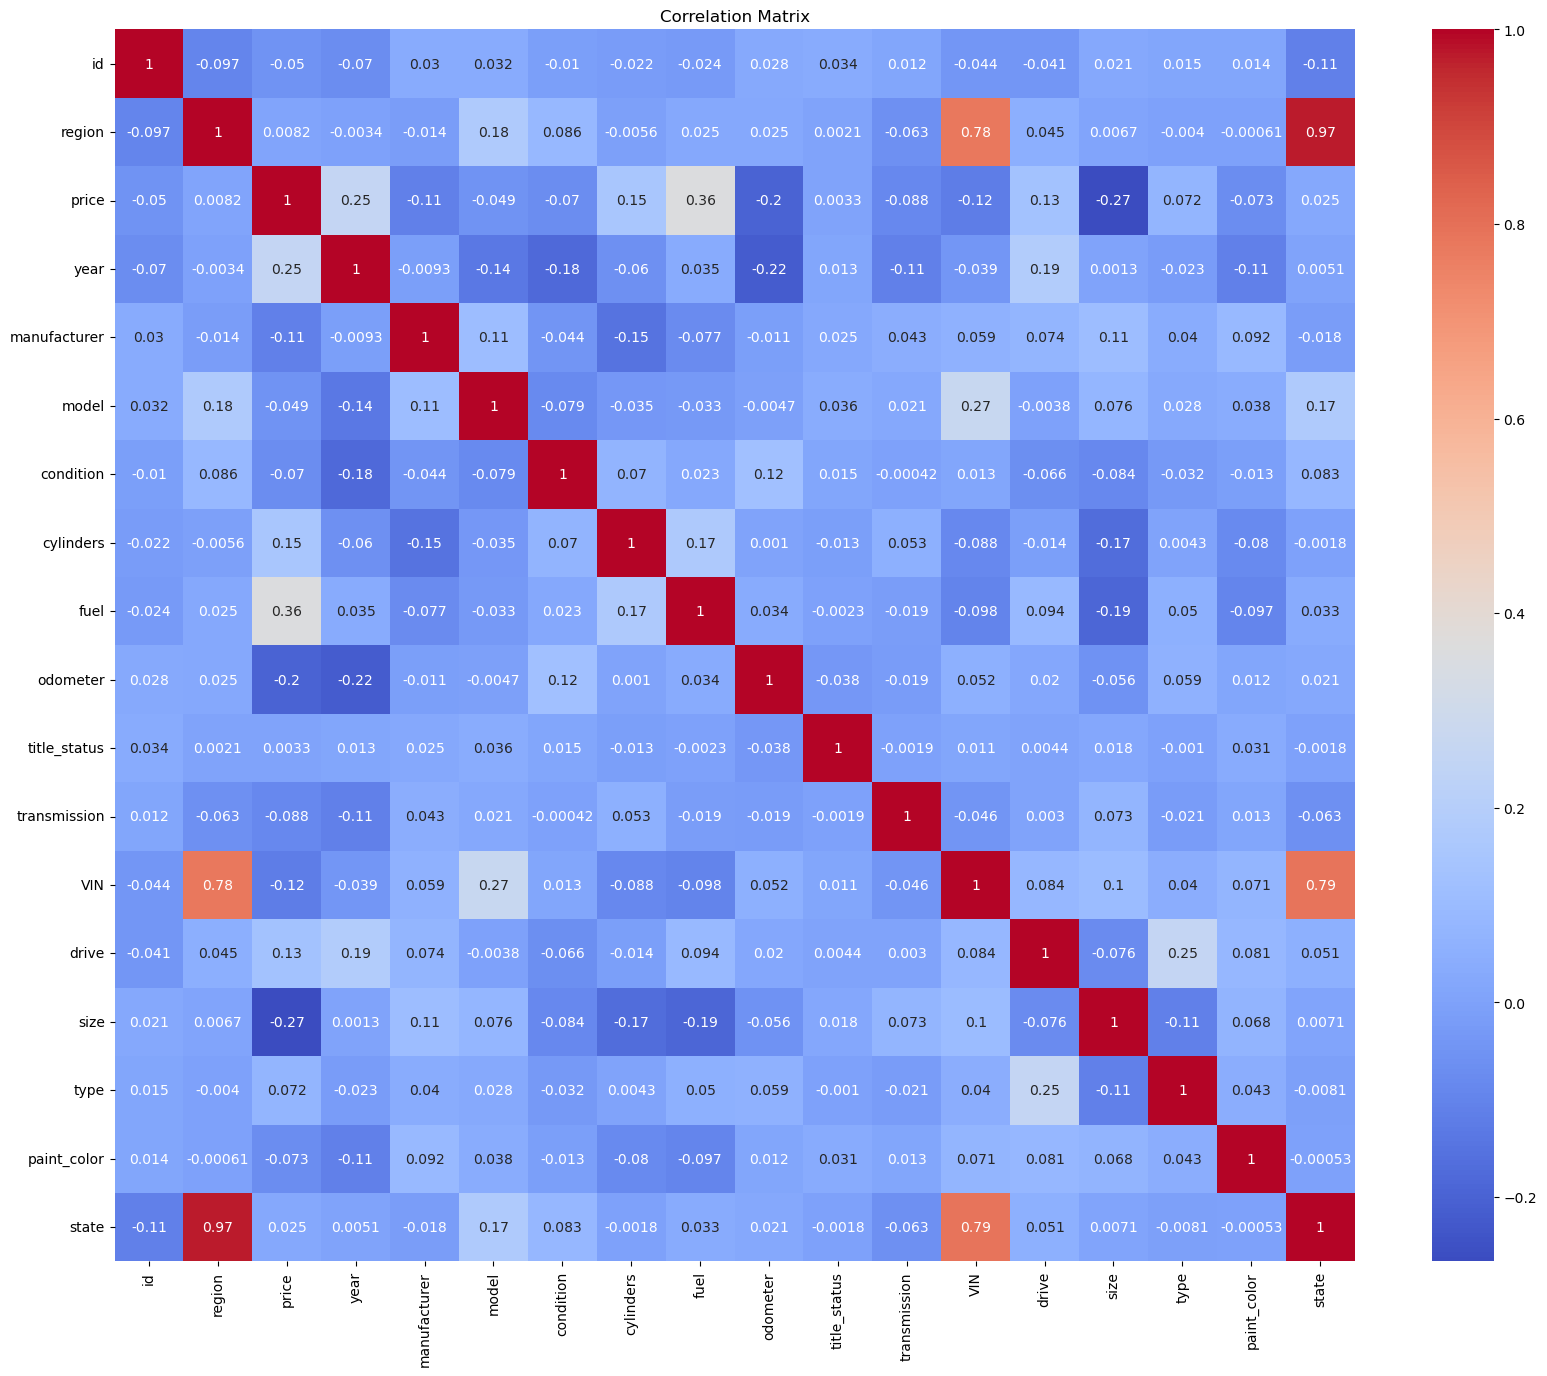

In [23]:
# Create a copy of the dataframe
clean_vehicles_heatmap = clean_vehicles.copy()

# Convert categorical columns to numeric columns
for col in clean_vehicles_heatmap.select_dtypes(include='object').columns:
    clean_vehicles_heatmap[col], _ = pd.factorize(clean_vehicles_heatmap[col])

    # Compute the correlation matrix
corr_matrix = clean_vehicles_heatmap.corr()

# Plot the heatmap matrix
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [30]:
# Group data by year and count number of cars - Result clearly tells that the data before 2000 is extremely negligible

cars_per_year = clean_vehicles.groupby('year')['manufacturer'].count()

# Calculate total number of cars before and after 2000
total_cars_before_2000 = cars_per_year[cars_per_year.index < 2000].sum()
total_cars_after_2000 = cars_per_year[cars_per_year.index >= 2000].sum()

# Print total number of cars
print("Total number of cars before 2000:", total_cars_before_2000)
print("Total number of cars after 2000:", total_cars_after_2000)

Total number of cars before 2000: 1305
Total number of cars after 2000: 33563


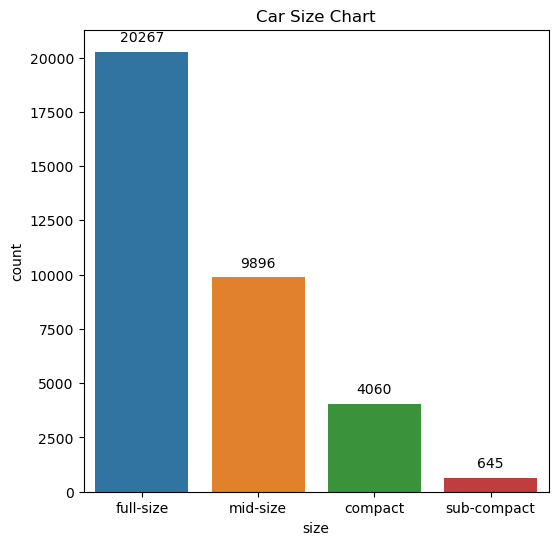

In [31]:
plt.figure(figsize = (6, 6))
ax = sns.countplot(x = 'size', data = clean_vehicles, order = clean_vehicles['size'].value_counts().index)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.title("Car Size Chart")
plt.show()

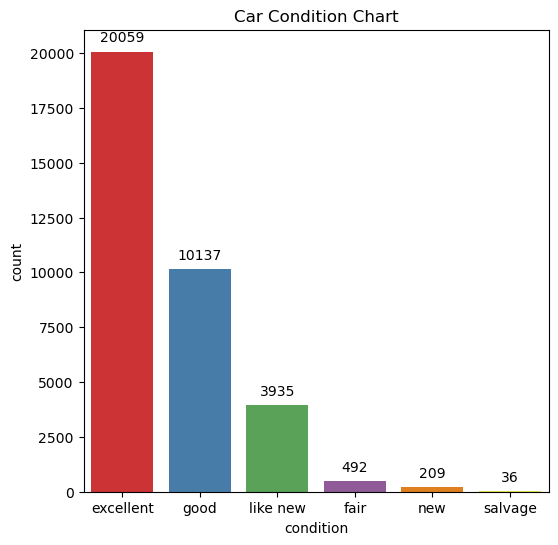

In [91]:
plt.figure(figsize = (6, 6))
ax = sns.countplot(x = 'condition', data = clean_vehicles, palette = 'Set1', order = clean_vehicles['condition'].value_counts().index)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.title("Car Condition Chart")
plt.show()

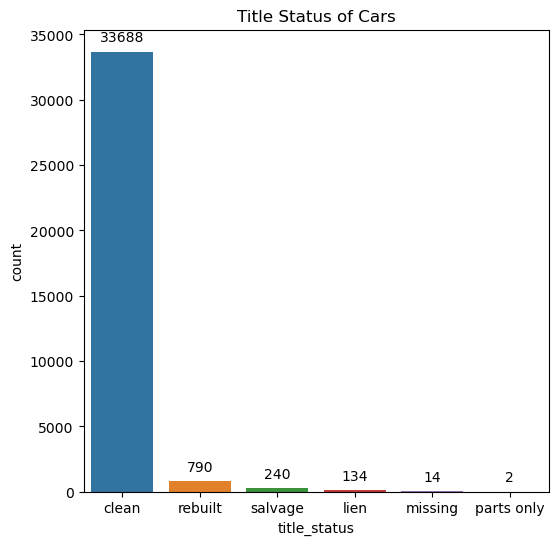

In [107]:
plt.figure(figsize = (6, 6))
ax = sns.countplot(x = 'title_status', data = clean_vehicles, order = clean_vehicles['title_status'].value_counts().index)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.title("Title Status of Cars")
plt.show()

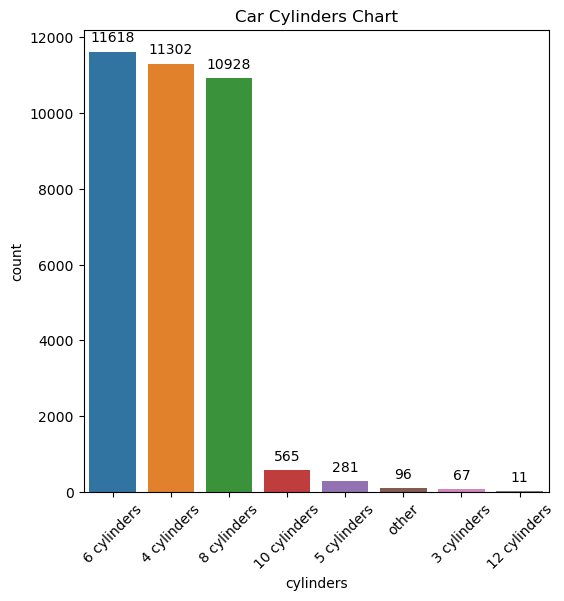

In [106]:
plt.figure(figsize = (6, 6))
ax = sns.countplot(x = 'cylinders', data = clean_vehicles, order = clean_vehicles['cylinders'].value_counts().index)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.title("Car Cylinders Chart")
plt.xticks(rotation = 45)
plt.show()

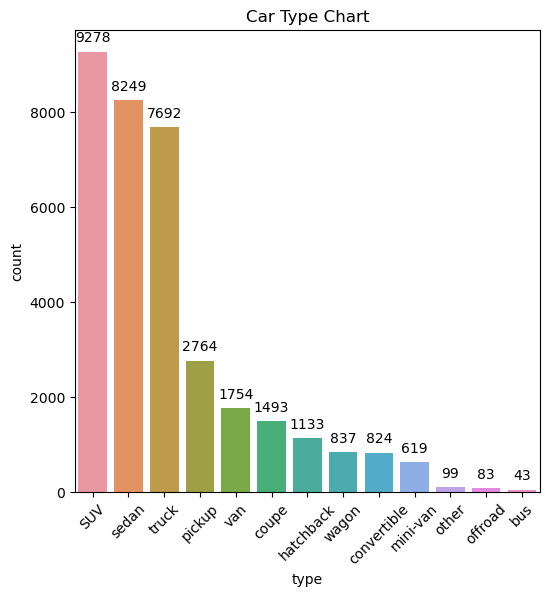

In [105]:
plt.figure(figsize = (6, 6))
ax = sns.countplot(x = 'type', data = clean_vehicles, order = clean_vehicles['type'].value_counts().index)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.title("Car Type Chart")
plt.xticks(rotation=45)
plt.show()

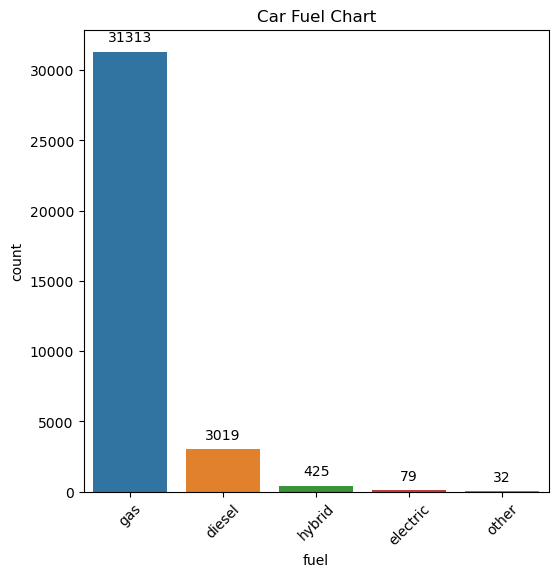

In [104]:
plt.figure(figsize = (6, 6))
ax = sns.countplot(x = 'fuel', data = clean_vehicles, order = clean_vehicles['fuel'].value_counts().index)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.title("Car Fuel Chart")
plt.xticks(rotation=45)
plt.show()

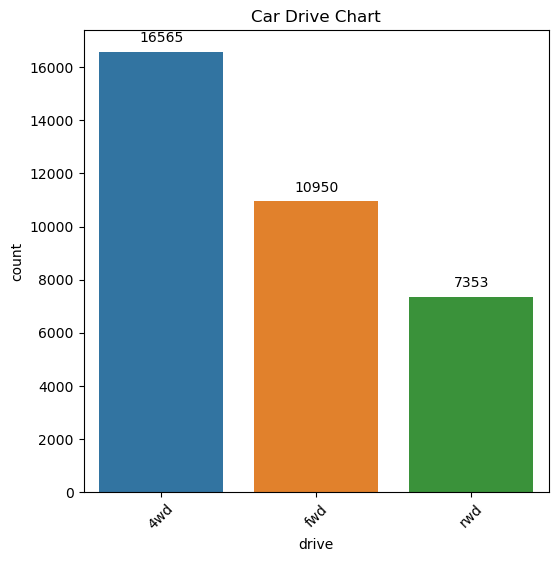

In [103]:
plt.figure(figsize = (6, 6))
ax = sns.countplot(x = 'drive', data = clean_vehicles, order = clean_vehicles['drive'].value_counts().index)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.title("Car Drive Chart")
plt.xticks(rotation=45)
plt.show()

(array([0, 1, 2, 3]),
 [Text(0, 0, 'full-size'),
  Text(1, 0, 'compact'),
  Text(2, 0, 'mid-size'),
  Text(3, 0, 'sub-compact')])

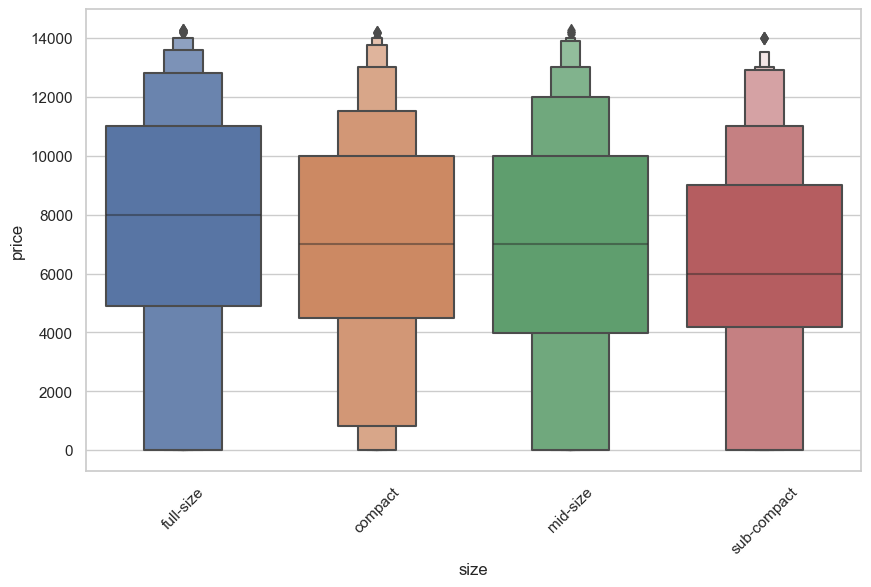

In [50]:
import seaborn as sns
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.boxenplot(x = 'size', y = 'price', data =clean_vehicles)
plt.xticks(rotation=45)

(array([0, 1, 2]), [Text(0, 0, 'rwd'), Text(1, 0, 'fwd'), Text(2, 0, '4wd')])

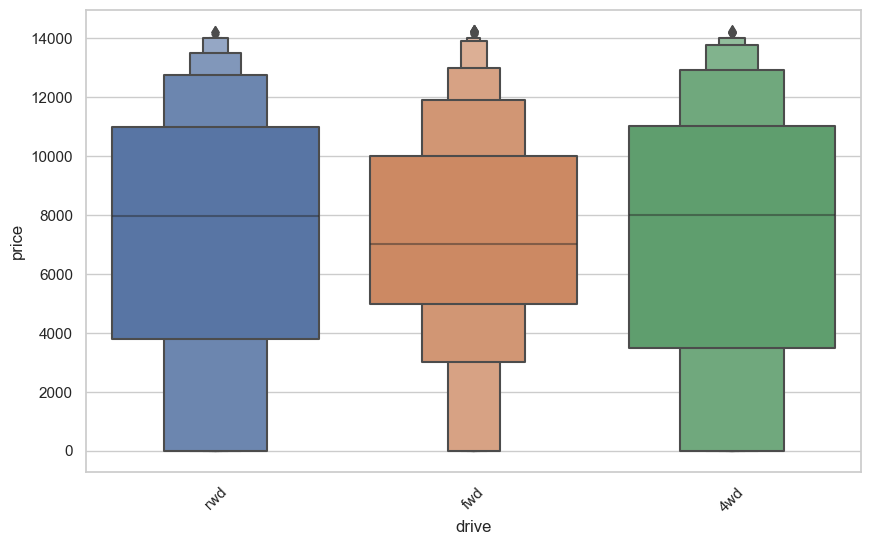

In [52]:
import seaborn as sns
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.boxenplot(x = 'drive', y = 'price', data =clean_vehicles)
plt.xticks(rotation=45)

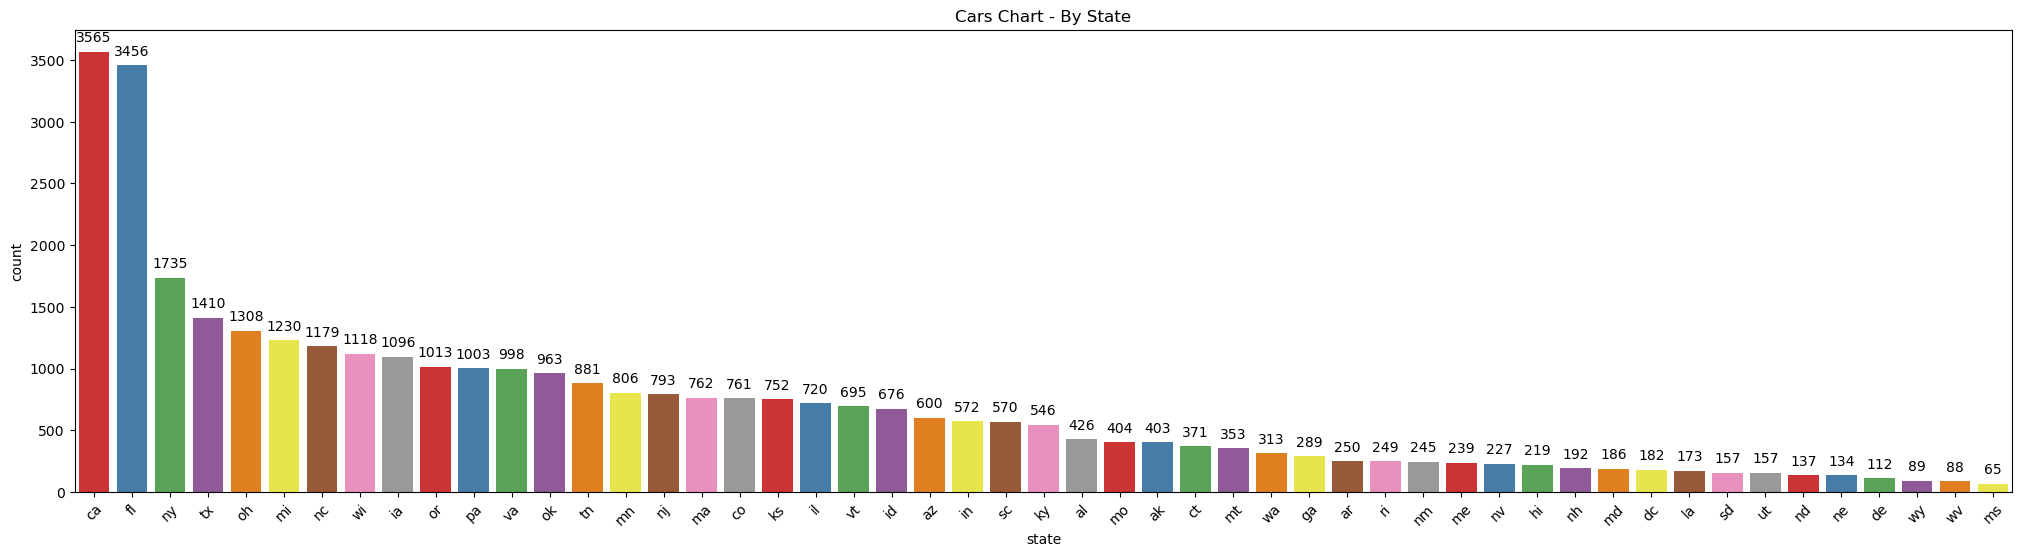

In [85]:
plt.figure(figsize = (25, 6))
ax = sns.countplot(x = 'state', data = clean_vehicles, palette = 'Set1', order = clean_vehicles['state'].value_counts().index)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.title("Cars Chart - By State")
plt.xticks(rotation=45)
plt.show()

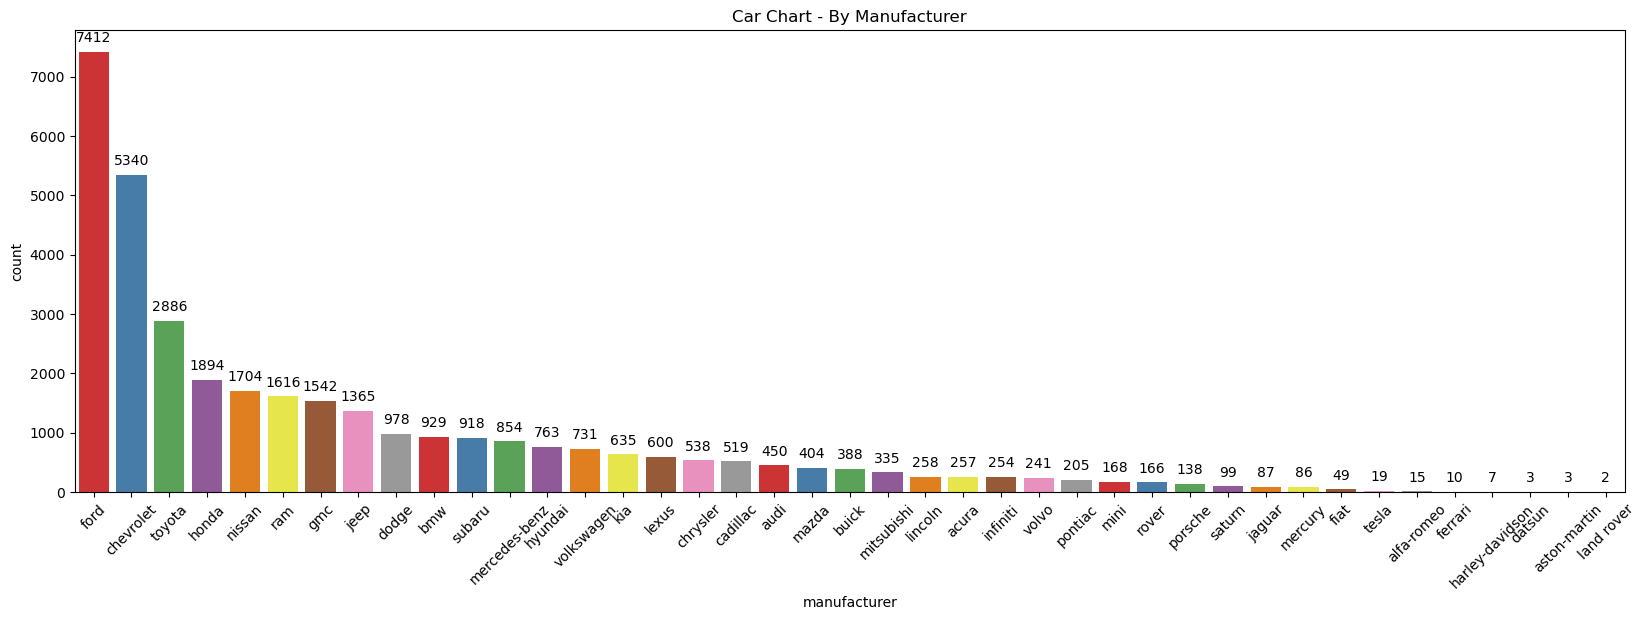

In [93]:
plt.figure(figsize = (20, 6))
ax = sns.countplot(x = 'manufacturer', data = clean_vehicles, palette = 'Set1', order = clean_vehicles['manufacturer'].value_counts().index)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.title("Car Chart - By Manufacturer")
plt.xticks(rotation=45)
plt.show()

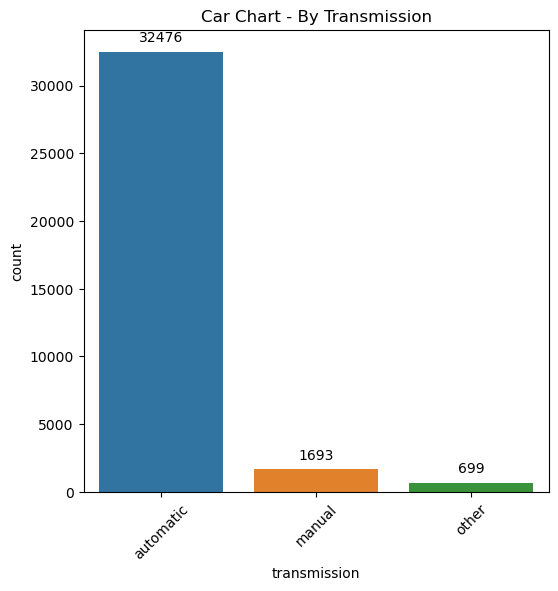

In [102]:
plt.figure(figsize = (6, 6))
ax = sns.countplot(x = 'transmission', data = clean_vehicles, order = clean_vehicles['transmission'].value_counts().index)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.title("Car Chart - By Transmission")
plt.xticks(rotation=45)
plt.show()

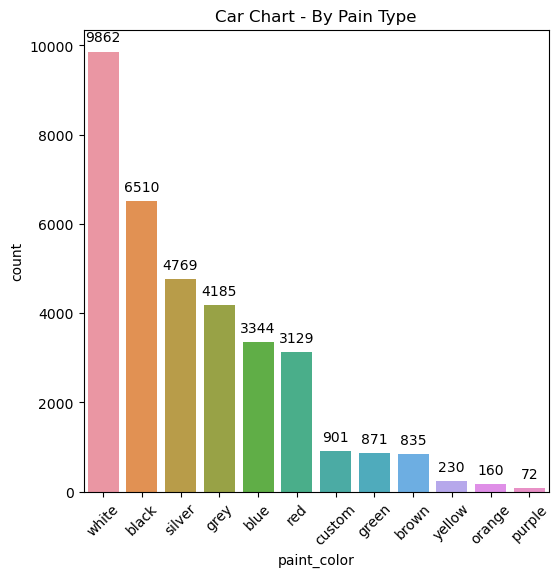

In [214]:
plt.figure(figsize = (6, 6))
ax = sns.countplot(x = 'paint_color', data = clean_vehicles, order = clean_vehicles['paint_color'].value_counts().index)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.title("Car Chart - By Pain Type")
plt.xticks(rotation=45)
plt.show()

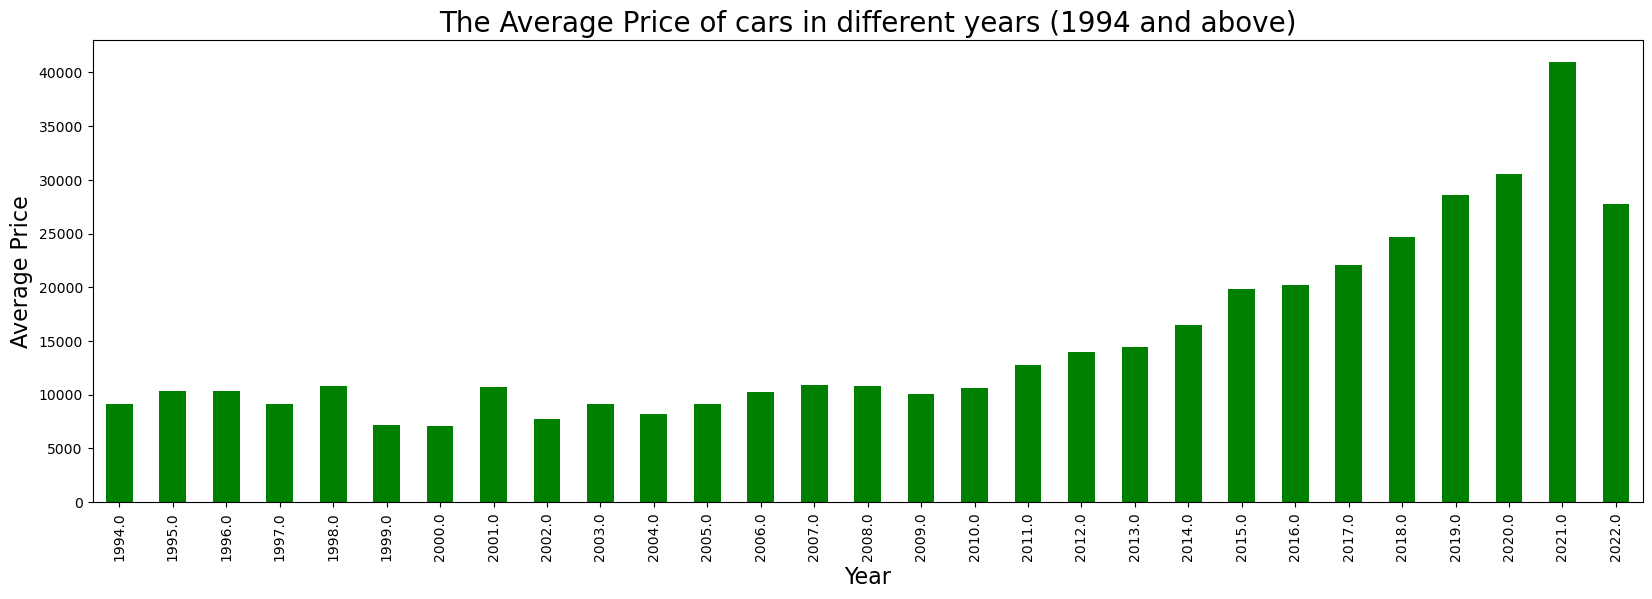

In [209]:
filtered_data = clean_vehicles[clean_vehicles['year'] >= 1994]

# Group the filtered data by year and compute the mean price
yearly_mean_price = filtered_data.groupby('year')['price'].mean()

# Sort the data by the mean price in descending order
yearly_mean_price_count = yearly_mean_price.sort_values(ascending=False)

# Plot the data
plt.figure(figsize=(20, 6))
yearly_mean_price.plot(kind='bar', color='g')

plt.title("The Average Price of cars in different years (1994 and above)", fontsize=20)
plt.xlabel("Year", fontsize=16)
plt.ylabel("Average Price", fontsize=16)
plt.show()

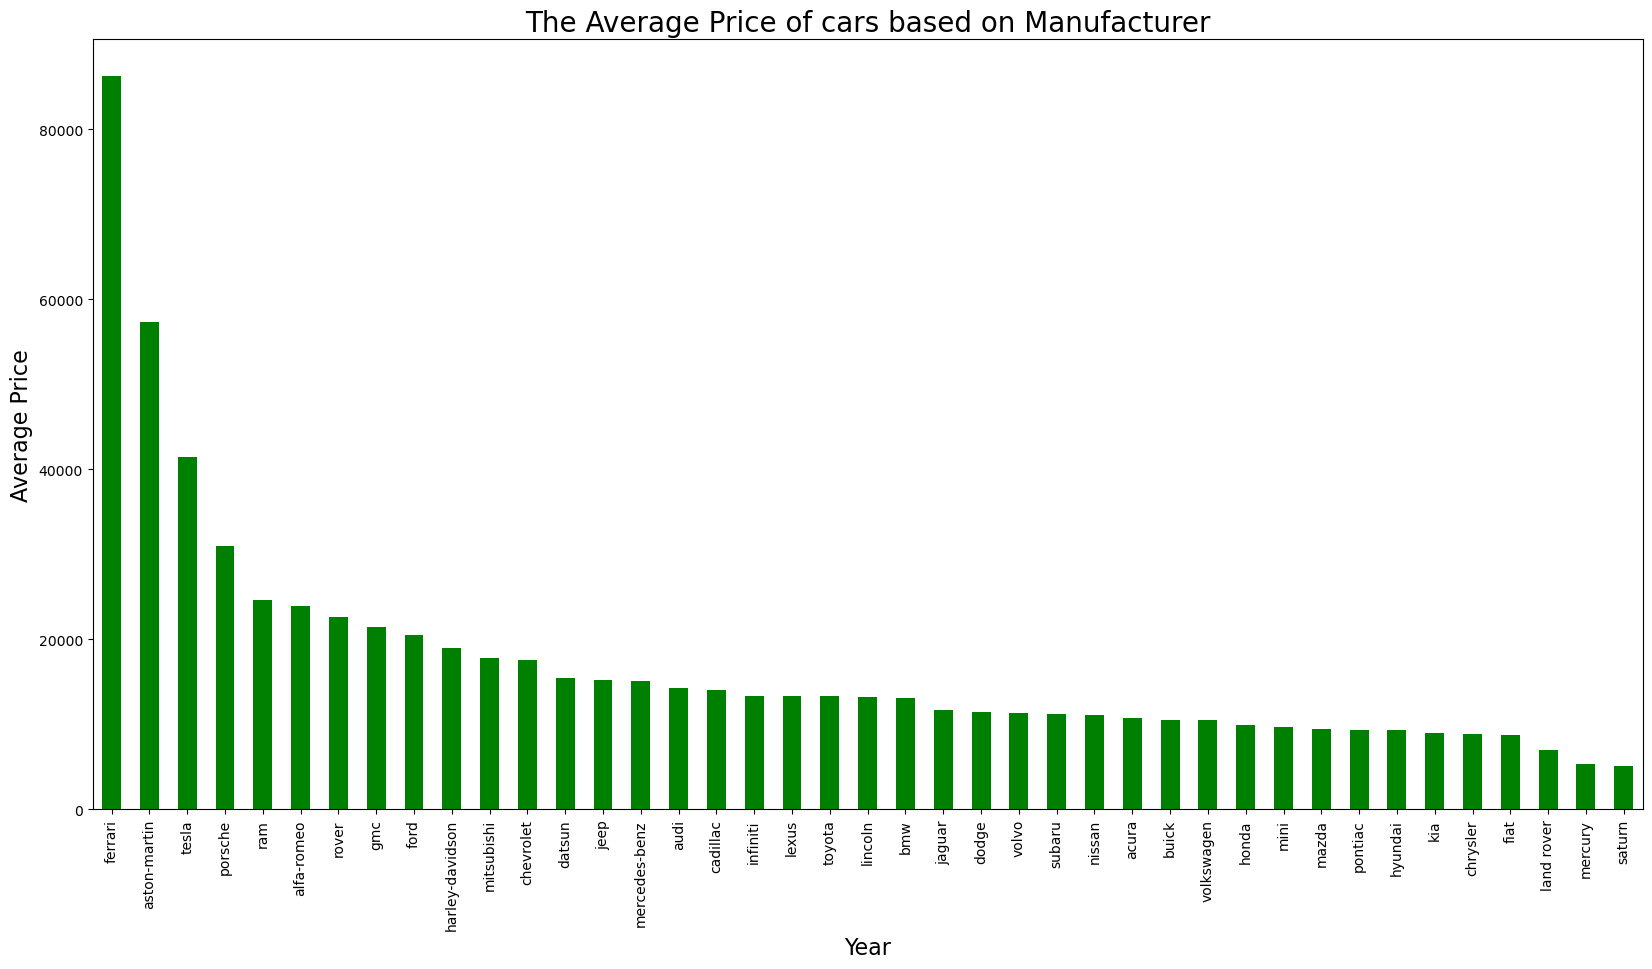

In [114]:
yearly_mean_price_sorted = clean_vehicles.groupby('manufacturer')['price'].mean().sort_values(ascending=False)

plt.figure(figsize=(20, 10))
yearly_mean_price_sorted.plot(kind='bar', color='g')
plt.title("The Average Price of cars based on Manufacturer", fontsize=20)
plt.xlabel("Year", fontsize=16)
plt.ylabel("Average Price", fontsize=16)
plt.show()

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [38]:
## Load data into dataframe
vehicles = pd.read_csv('data/Vehicles.csv')

## Drop NaN and duplicates form the dataset
clean_vehicles = vehicles.dropna()
clean_vehicles = clean_vehicles.drop_duplicates()
clean_vehicles.shape

(34868, 18)

In [39]:
#After exploring the data, it is clear that columns id, region and VIN are inconsequential columns and hence will be dropped from the dataset to be used for ML modeling.
clean_vehicles = clean_vehicles.drop(columns = ['id', 'region', 'VIN', 'paint_color'])

<Axes: xlabel='price'>

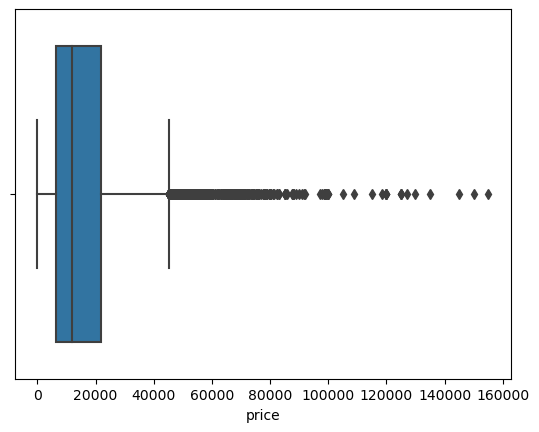

In [5]:
sns.boxplot(data=clean_vehicles, x='price')

In [344]:
clean_vehicles['price'].describe()

count     34868.000000
mean      15837.446771
std       13460.056823
min           0.000000
25%        6500.000000
50%       12000.000000
75%       22003.500000
max      155000.000000
Name: price, dtype: float64

Above description of price column values along with the chart clearly describes that the standard deviation of price column is very wide. Suggests that there is a potential for outliers., which should be removed.
Will adjust the data to remove the outliers and try to bring the data more normally distributed for better and accurate prediction.

In [40]:
# get the 25th and 75th percentiles
Q1 = clean_vehicles['price'].quantile(0.25)
Q3 = clean_vehicles['price'].quantile(0.75)
# get the interquartile range
IQR = Q3 - Q1

In [41]:
clean_vehicles = clean_vehicles[~((clean_vehicles['price'] < (Q1 - IQR) ) | (clean_vehicles['price'] > (Q3 - 0.5*IQR)))]
clean_vehicles.shape

(19785, 14)

In [31]:
clean_vehicles = clean_vehicles[clean_vehicles['price'] != 0]
clean_vehicles['price'].describe()

count    17413.000000
mean      7829.247344
std       3643.842079
min          1.000000
25%       5295.000000
50%       7988.000000
75%      10800.000000
max      14250.000000
Name: price, dtype: float64

<Axes: xlabel='price'>

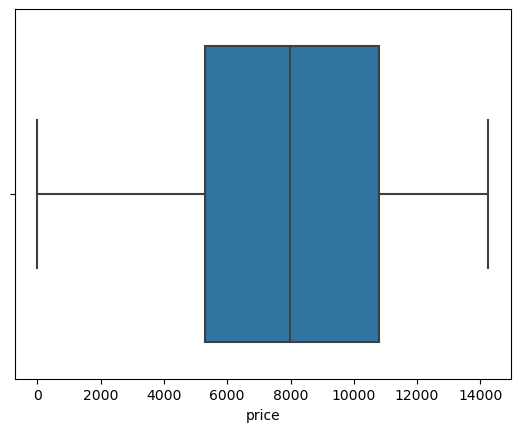

In [30]:
sns.boxplot(data=clean_vehicles_df, x='price')

### Based on my data analysis from above charts and running queries, following are my observations and hence I am preparing the data accordingly for effective modeling.

1. Year - Has the 2nd highest correlation with price (0.25) based on heatmap. But upon closer look, only 3.7% of data is from before 2000 and hence that data will be deleted.
2. Fuel - Has the highest correlation with price (0.36) based on heatmap. Gas and Diesel cover for 98.5% of the data and hence remaining all will be categorized as other
3. Cylinder - 4, 6 and 8 cyclinder vehicles comprise of 97% of the data and hence remaining data will be moved under other.
4. Title_Status - 97% of overall vehicles have clean title status. Moving rest of the data under other
5. Condition - Between Excellent, Like New and Good cover for ~98% data and hence moving remaining fields under other.
6. Transmission - 94% of records are Automatic and hence moved remaining records under other category



In [42]:
# Filter data by year
clean_vehicles = clean_vehicles[clean_vehicles['year'] >= 2000]


# Retaining only records with Title Status as clean and then deleting entire title status column
clean_vehicles = clean_vehicles[clean_vehicles['title_status'] == 'clean']
clean_vehicles = clean_vehicles.drop(columns=['title_status'])

# Modify Fuel records data
mask = ~clean_vehicles['fuel'].isin(['gas', 'diesel'])
clean_vehicles.loc[mask, 'fuel'] = 'other'
clean_vehicles = clean_vehicles[clean_vehicles['fuel'] != 'other']

# Modify Cylinders records data
mask = ~clean_vehicles['cylinders'].isin(['4 cylinders', '6 cylinders', '8 cylinders'])
clean_vehicles.loc[mask, 'cylinders'] = 'other'
clean_vehicles = clean_vehicles[clean_vehicles['cylinders'] != 'other']

# Modify Condition records data
mask = ~clean_vehicles['condition'].isin(['excellent', 'good', 'like new'])
clean_vehicles.loc[mask, 'condition'] = 'other'
clean_vehicles = clean_vehicles[clean_vehicles['condition'] != 'other']

# Modify Condition records data
mask = ~clean_vehicles['transmission'].isin(['automatic'])
clean_vehicles.loc[mask, 'transmission'] = 'other'
clean_vehicles = clean_vehicles[clean_vehicles['transmission'] != 'other']
clean_vehicles = clean_vehicles.drop(columns=['transmission'])


print(f'After cleaning up the data, total num of records in the dataset: {clean_vehicles.shape}.')

After cleaning up the data, total num of records in the dataset: (15691, 12).


In [43]:
## While year column is very valuable but the real value is around how old the car is. We will compute that value and insert it into our dataframe.
clean_vehicles['current_year'] = 2023
clean_vehicles['vehicle_age'] = clean_vehicles['current_year'] - clean_vehicles['year']
clean_vehicles.drop(['current_year'], inplace = True, axis = 1)

In [44]:
# We can now drop year column
clean_vehicles.drop(['year'], inplace=True, axis=1)

### Splitting data based on Condition of the car. Following are some benefits.
1. Model can run faster
2. Cleaner modeling, especially keeping customer's (used car dealer) needs in perspective. Usually, used car dealers, segment cars based on condition
3. Easier to manage the model and data.

### Time permitting, I will run all the models against the split of this data so that we can provide information to customers (car dealers) based on car segmentation

In [46]:
# Create dataframes for each condition
excellent_df = clean_vehicles[clean_vehicles['condition'] == 'excellent']
good_df = clean_vehicles[clean_vehicles['condition'] == 'good']
like_new_df = clean_vehicles[clean_vehicles['condition'] == 'like new']

# Print number of records in each dataframe
print("Number of records in excellent dataframe:", len(excellent_df))
print("Number of records in good dataframe:", len(good_df))
print("Number of records in like new dataframe:", len(like_new_df))

Number of records in excellent dataframe: 9553
Number of records in good dataframe: 4801
Number of records in like new dataframe: 1337


### Preparing data for modeling

Splitting into features (X) and target (y).

Creating training and test data sets from original data set, with a split of 70/30

In [47]:
X = clean_vehicles.drop('price', axis=1)
y = clean_vehicles['price']

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 
Categorical Columns and Numerical Columns to encode the data so that categorical values will be converted to numericals using category_encoders and then scaled so that they can be used for ML operations can be performed

In [53]:
# Define categorical and numerical features
cat_features = ['manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'drive', 'size', 'type', 'state']
num_features = ['odometer', 'vehicle_age']

# Define pipeline for encoding and scaling data
cat_encoder = OneHotEncoder(handle_unknown='ignore')
scaler = StandardScaler(with_mean=False)
preprocessor = Pipeline([('cat_encoder', cat_encoder), ('scaler', scaler)])

# Fit and transform training data using pipeline
X_train_encoded_scaled = preprocessor.fit_transform(X_train)
X_test_encoded_scaled = preprocessor.transform(X_test)

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

### Creating a baseline

In [54]:
baseline_train = np.ones(shape = y_train.shape)*y_train.mean()
baseline_test = np.ones(shape = y_test.shape)*y_test.mean()
mse_baseline_train = mean_squared_error(baseline_train, y_train)
mse_baseline_test = mean_squared_error(baseline_test, y_test)

print(baseline_train.shape, baseline_test.shape)
print(f'Baseline for training data: {mse_baseline_train}')
print(f'Baseline for testing data: {mse_baseline_test}')

(10983,) (4708,)
Baseline for training data: 17983493.400175348
Baseline for testing data: 17626668.429936275


### A simple model just based on one feature, odometer.

In [55]:
model_1_train_mse = ''
model_1_test_mse = ''

### BEGIN SOLUTION
X1 = X_train[['odometer']]
lr = LinearRegression().fit(X1, y_train)
model_1_train_mse = mean_squared_error(y_train, lr.predict(X1))
model_1_test_mse = mean_squared_error(y_test, lr.predict(X_test[['odometer']]))
### END SOLUTION

# Answer check
print(f'Train MSE: {model_1_train_mse: .2f}')
print(f'Test MSE: {model_1_test_mse: .2f}')

Train MSE:  17960419.54
Test MSE:  17619505.02


### Linear Regression

In [56]:
lr = LinearRegression()
lr.fit(X_train_encoded_scaled, y_train)
lr_test_preds = lr.predict(X_test_encoded_scaled)
lr_train_preds = lr.predict(X_train_encoded_scaled)
lr_mse_test = mean_squared_error(y_test, lr_test_preds)
lr_mse_train = mean_squared_error(y_train, lr_train_preds)
lr_mae_test = mean_absolute_error(y_test, lr_test_preds)
lr_mae_train = mean_absolute_error(y_train, lr_train_preds)
print(f'MSE for Test Data on Linear Regression: {lr_mse_test}')
print(f'MSE for Training Data on Linear Regression: {lr_mse_train}')
print(f'MAE for Test Data on Linear Regression: {lr_mae_test}')
print(f'MAE for Training Data on Linear Regression: {lr_mae_train}')

MSE for Test Data on Linear Regression: 10168843.6388017
MSE for Training Data on Linear Regression: 388382.14479630574
MAE for Test Data on Linear Regression: 1930.797141101753
MAE for Training Data on Linear Regression: 194.22939205281864


In [90]:
# Combine feature names for encoded categorical features and numerical features
feature_names = np.concatenate([cat_features, num_features])

# Get coefficients of linear regression model
lr_coef = lr.coef_

# Print coefficients along with feature names
for i in range(len(feature_names)):
    print(f'{feature_names[i]}: {lr_coef[i]}')

manufacturer: 26.005642071172456
model: -4.448694080217264
condition: 18.68189897864661
cylinders: -106.86860740286592
fuel: 62.60127368556632
drive: 18.022246601178054
size: -64.91831102092374
type: -91.17628350215946
state: -32.97409120862679
odometer: 29.008487691103387
vehicle_age: 57.73763176277756


### Sequential Feature Selection

In [57]:
# Sequential Feature Selection model
sfs = SequentialFeatureSelector(lr, n_features_to_select=5)
sfs.fit(X_train_encoded_scaled, y_train)

X_train_sfs = sfs.transform(X_train_encoded_scaled)
X_test_sfs = sfs.transform(X_test_encoded_scaled)

lr_sfs = LinearRegression().fit(X_train_sfs, y_train)

sfs_test_preds = lr_sfs.predict(X_test_sfs)
sfs_train_preds = lr_sfs.predict(X_train_sfs)
sfs_mse_test = mean_squared_error(y_test, sfs_test_preds)
sfs_mse_train = mean_squared_error(y_train, sfs_train_preds)
sfs_mae_test = mean_absolute_error(y_test, sfs_test_preds)
sfs_mae_train = mean_absolute_error(y_train, sfs_train_preds)
print(f'MSE for Test Data on Sequential Feature Selection: {sfs_mse_test}')
print(f'MSE for Training Data on Sequential Feature Selection: {sfs_mse_train}')
print(f'MAE for Test Data on Sequential Feature Selection: {sfs_mae_test}')
print(f'MAE for Training Data on Sequential Feature Selection: {sfs_mae_train}')

MSE for Test Data on Sequential Feature Selection: 15325211.315186383
MSE for Training Data on Sequential Feature Selection: 15707653.467373928
MAE for Test Data on Sequential Feature Selection: 3198.4019539976184
MAE for Training Data on Sequential Feature Selection: 3256.6404485193775


In [ ]:
best_features = sfs.fit_transform(X_train_encoded_scaled, y_train)

In [59]:
input_features = preprocessor.named_steps['cat_encoder'].feature_names_in_
selected_features = np.array(preprocessor.named_steps.cat_encoder.get_feature_names_out(input_features))[sfs.get_support()]

# Print selected feature names
print("Selected Features:")
for feature in selected_features:
    print(feature)

Selected Features:
state_oh
state_ok
vehicle_age_3.0
vehicle_age_4.0
vehicle_age_5.0


In [92]:
# Get coefficients of linear regression model
lr_sfs_coef = lr_sfs.coef_

# Print coefficients along with selected feature names
for i in range(len(selected_features)):
    print(f'{selected_features[i]}: {lr_sfs_coef[i]}')

state_oh: -506.4664483250652
state_ok: -746.3713362646998
vehicle_age_3.0: -465.6653570357745
vehicle_age_4.0: -662.1609650190964
vehicle_age_5.0: -746.4408834460336


### Ridge Model

In [60]:
# Ridge Regression model with GridSearchCV
ridge = Ridge()
param_grid = {'alpha': np.logspace(0, 1, 100)}
grid_search_ridge = GridSearchCV(ridge, param_grid, cv=5)
grid_search_ridge.fit(X_train_encoded_scaled, y_train)
best_ridge = grid_search_ridge.best_estimator_
best_ridge.fit(X_train_encoded_scaled, y_train)

Ridge(alpha=10.0)

### Coeff and best features for Ridge Regression

In [61]:
# Print coefficients and best features for Ridge Regression model
print("Ridge Regression - Best alpha:", grid_search_ridge.best_params_['alpha'])
print("Best score:", grid_search_ridge.best_score_)
print("MSE for Training Data on Ridge Regression:", mean_squared_error(y_train, best_ridge.predict(X_train_encoded_scaled)))
print("MSE for Test Data on Ridge Regression:", mean_squared_error(y_test, best_ridge.predict(X_test_encoded_scaled)))
print("MAE for Training Data on Ridge Regression:", mean_absolute_error(y_train, best_ridge.predict(X_train_encoded_scaled)))
print("MAE for Test Data on Ridge Regression:", mean_absolute_error(y_test, best_ridge.predict(X_test_encoded_scaled)))

Ridge Regression - Best alpha: 10.0
Best score: 0.35610270844401704
MSE for Training Data on Ridge Regression: 389146.636019778
MSE for Test Data on Ridge Regression: 9860916.361247648
MAE for Training Data on Ridge Regression: 197.20178751534647
MAE for Test Data on Ridge Regression: 1911.5940184092767


In [62]:
input_features = preprocessor.named_steps['cat_encoder'].feature_names_in_
cat_cols = preprocessor.named_steps.cat_encoder.get_feature_names_out(input_features)
coef_df = pd.DataFrame({'Alpha': best_ridge.alpha, 'Feature': cat_cols, 'Coefficient': best_ridge.coef_})

In [64]:
coef_df.head(10)

,Alpha,Feature,Coefficient
0,10.0,manufacturer_acura,30.227920
1,10.0,manufacturer_audi,3.322605
2,10.0,manufacturer_bmw,24.735824
3,10.0,manufacturer_buick,-98.918938
4,10.0,manufacturer_cadillac,60.596370
5,10.0,manufacturer_chevrolet,3.419643
6,10.0,manufacturer_chrysler,-61.206767
7,10.0,manufacturer_dodge,-90.035889
8,10.0,manufacturer_fiat,-31.156740
9,10.0,manufacturer_ford,9.635809


### Lasso Model - 

- Could not run this model on my laptop as it was killing the kernal. Will try to run after segmenting the data set based on the condition of the car.

In [ ]:
# Lasso model with GridSearchCV
lasso = Lasso()
param_grid = {'alpha': np.logspace(0, 1, 100)}
grid_search_lasso = GridSearchCV(lasso, param_grid, cv=5)
grid_search_lasso.fit(X_train_encoded_scaled, y_train)
best_lasso = grid_search_lasso.best_estimator_
best_lasso.fit(X_train_encoded_scaled, y_train)

In [ ]:
lasso_test_preds = best_lasso.predict(X_test_encoded_scaled)
lasso_train_preds = best_lasso.predict(X_train_encoded_scaled)
lasso_mse_test = mean_squared_error(y_test, lasso_test_preds)
lasso_mse_train = mean_squared_error(y_train, lasso_train_preds)
lasso_mae_test = mean_absolute_error(y_test, lasso_test_preds)
lasso_mae_train = mean_absolute_error(y_train, lasso_train_preds)
print(f'MSE for Test Data on Linear Regression: {lasso_mse_test}')
print(f'MSE for Training Data on Linear Regression: {lasso_mse_train}')
print(f'MAE for Test Data on Linear Regression: {lasso_mae_test}')
print(f'MAE for Training Data on Linear Regression: {lasso_mae_train}')

### MSE and MAE for each model on training and test data

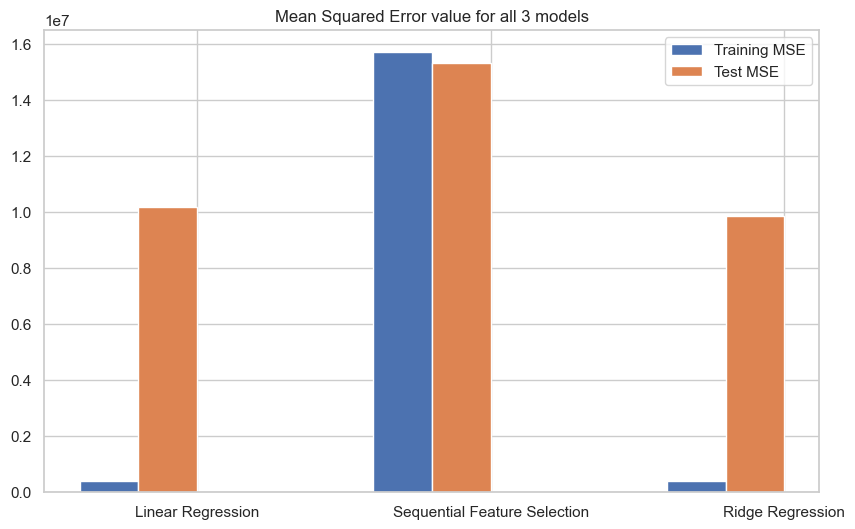

In [85]:
models = [lr, lr_sfs, best_ridge]#, best_lasso]
model_names = ['Linear Regression', 'Sequential Feature Selection', 'Ridge Regression']#, 'Lasso']
train_mse = []
test_mse = []
train_mae = []
test_mae = []

# Calculate MSE and MAE for each model
for i in range(len(models)):
    model = models[i]
    name = model_names[i]
    if name == 'Sequential Feature Selection':
        y_pred_train = model.predict(X_train_sfs)
        y_pred_test = model.predict(X_test_sfs)
    else:
        y_pred_train = model.predict(X_train_encoded_scaled)
        y_pred_test = model.predict(X_test_encoded_scaled)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    train_mse.append(mse_train)
    test_mse.append(mse_test)
    train_mae.append(mae_train)
    test_mae.append(mae_test)

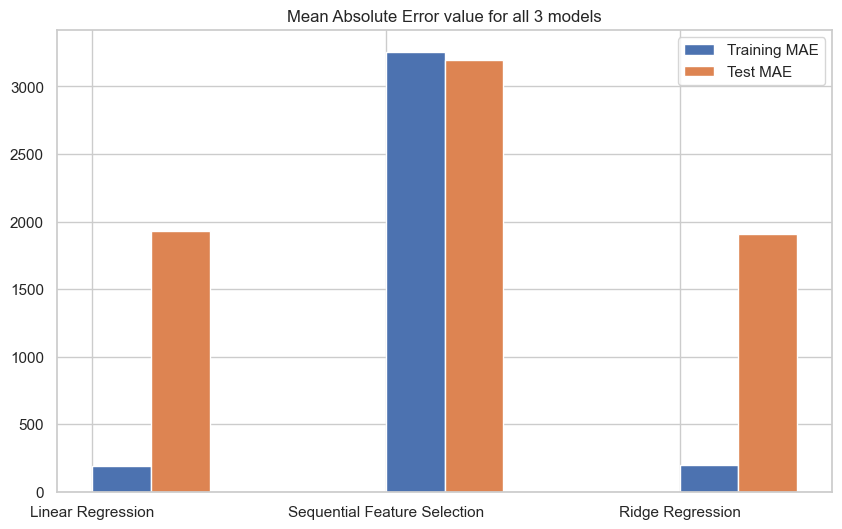

In [86]:
# Create bar chart
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(models))
width = 0.2
ax.bar(x + 0.5*width, train_mae, width, label='Training MAE')
ax.bar(x + 1.5*width, test_mae, width, label='Test MAE')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.set_title('Mean Absolute Error value for all 3 models')
ax.legend()
plt.show()

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.